In [1]:
from typing import Optional
from multiprocessing import Pool

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import math
from torch._C import dtype
from typing import Dict
from models.siren_model import Siren
from models.very_tiny_nerf_model import VeryTinyNerfModel
import deepCABAC
from torchinfo import summary



In [2]:
DTYPE_BIT_SIZE: Dict[dtype, int] = {
    torch.float32: 32,
    torch.float: 32,
    torch.float64: 64,
    torch.double: 64,
    torch.float16: 16,
    torch.half: 16,
    torch.bfloat16: 16,
    torch.complex32: 32,
    torch.complex64: 64,
    torch.complex128: 128,
    torch.cdouble: 128,
    torch.uint8: 8,
    torch.int8: 8,
    torch.int16: 16,
    torch.short: 16,
    torch.int32: 32,
    torch.int: 32,
    torch.int64: 64,
    torch.long: 64,
    torch.bool: 1
}

def model_size_in_bits(model):
    """Calculate total number of bits to store `model` parameters and buffers."""
    return sum(sum(t.nelement() * DTYPE_BIT_SIZE[t.dtype] for t in tensors)
               for tensors in (model.parameters(), model.buffers()))

In [3]:
def clamp_image(img):
    """Clamp image values to like in [0, 1] and convert to unsigned int.
    Args:
        img (torch.Tensor):
    """
    # Values may lie outside [0, 1], so clamp input
    img_ = torch.clamp(img, 0., 1.)
    # Pixel values lie in {0, ..., 255}, so round float tensor
    return torch.round(img_ * 255) / 255.
    
def psnr(img1, img2):
    """Calculates PSNR between two images.
    Args:
        img1 (torch.Tensor):
        img2 (torch.Tensor):
    """
    return 20. * np.log10(1.) - 10. * (img1 - img2).detach().pow(2).mean().log10().to('cpu').item()

In [4]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('CUDA version:', torch.version.cuda)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')

Using device: cuda
CUDA version: 11.2

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
# cap = cv2.VideoCapture("../datasets/00003.mp4")
# cap = cv2.VideoCapture("../datasets/fireworks_128.mp4")
cap = cv2.VideoCapture("../datasets/lego_128.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# total_frames = 15


def complex_vid(width=100, height=100, frames=100):
  """Peak complexity video. Random pixel values for all coords at each frame."""
  return torch.rand(frames, width, height, 3)

def get_frame(idx):
  r""" Get the RGB tensor of a specific frame in the video.
  """
  cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
  success, img = cap.read()
  if not success:
    print("Failed to load frame at index " + str(idx))
  return torch.from_numpy(np.float32(img) / 255)

frames = torch.stack([get_frame(i) for i in range(total_frames)])
frames = frames.to(device)

In [7]:
def xs_and_ys(width, height, frame_ind):
    r""" Construct (x, y, f) tuples.
    """

    coordinates = torch.ones([height,width]).nonzero(as_tuple=False).float()


    #Assuming the image is square is necessary for this nice vector operation
    #Change if we use non-square image
    coordinates = coordinates/ (height - 1) - 0.5

    fill_val =  frame_ind/(total_frames -1) - 0.5
    frame_indicies = torch.full((coordinates.shape[0], 1), fill_val)
    coordinates = torch.cat([coordinates, frame_indicies], -1)
 
    coordinates *= 2
    return coordinates



In [8]:

def positional_encoding_old(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
          0.0,
          num_encoding_functions - 1,
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

def positional_encoding(
    tensor, num_encoding_functions = [6,6,6], std_dev = 1.4, include_input=True, log_sampling=True
) -> torch.Tensor:
    r"""Apply positional encoding to the input.

    Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    std_dev (optional, int): Scale parameter/standard deviation, replaces the default two used in Nerf
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    # TESTED
    # Trivially, the input tensor is added to the positional encoding.

    encoding = [tensor] if include_input else []

    # Now, encode the input using a set of high-frequency functions and append the
    # resulting values to the encoding.
    frequency_bands = None
    if log_sampling:
        frequency_bands =[ std_dev ** torch.linspace(
            0.0,
            n - 1,
            n,
            dtype=tensor.dtype,
            device=tensor.device,
        ) for n in num_encoding_functions]

    else:
        frequency_bands = [ torch.linspace(
            std_dev ** 0.0,
            std_dev ** (n - 1),
            n,
            dtype=tensor.dtype,
            device=tensor.device,
        ) for n in num_encoding_functions ]
        
    max_enc_len = np.max(num_encoding_functions)    
    for i in range(0, max_enc_len):
            for func in [torch.sin, torch.cos]:
                for j in range(0, len(num_encoding_functions)):
                    freq_band = frequency_bands[j]
                    if i < len(freq_band):
                        encoding.append(func(tensor[:, j:j+1] * freq_band[i]))
                   

    # Special case, for no positional encoding
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)

In [9]:
def gaussian_encoding(tensor, num_encoding_functions=[6, 6, 6], std_dev=0.003, include_input=True):

    encoding = [tensor] if include_input else []

    frequency_bands = [torch.linspace(
            0.0,
            n - 1,
            n,
            dtype=tensor.dtype,
            device=tensor.device,
        ) for n in num_encoding_functions]

    max_enc_len = np.max(num_encoding_functions)
    for i in range(0, max_enc_len):
            for j in range(0, len(num_encoding_functions)):
                freq_band = frequency_bands[j]
                if i < len(freq_band):
                    encoding.append(torch.exp(-torch.pow((freq_band[i] - tensor[:, j:j+1]), 2) / (2 * std_dev**2)))

    # Special case, for no positional encoding
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)


In [10]:
encoded = {}

# def changed_chunk():
#   encoded.clear()

def get_encoding(frame_ind, height, width, encoding_fn):
  if not (frame_ind, height, width) in encoded:
    pts = xs_and_ys(width, height, frame_ind)
    encoded_pts = encoding_fn(pts)
    encoded[(frame_ind, height, width)] = encoded_pts
  else:
    encoded_pts = encoded[(frame_ind, height, width)]
  return encoded_pts

def one_iter_npc(width, height, model, frame_ind, encoding_fn, get_minibatches_fn):
  encoded_pts = get_encoding(frame_ind, height, width, encoding_fn)
  
  rgb_flat = model(encoded_pts)
  rgb = torch.reshape(rgb_flat, [height, width, 3])
  return rgb

In [11]:
def output_video(fps, width: int, height: int, encode, get_minibatches):
  r"""Build the final video from the trained model."""
  out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  def output_v(start_frame, end_frame, model):
    for f in range(start_frame, end_frame):
        rgb_predicted = clamp_image(one_iter_npc(width, height, model,
                                     f, encode,
                                     get_minibatches))

        rgb_out = cv2.normalize(src=rgb_predicted.detach().cpu().numpy(), dst=None, alpha=0, beta=255,
                                norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        out.write(rgb_out)
    return lambda: out.release()

  return output_v

In [12]:
import pickle
def get_new_chunk():
  # model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions,
  #                           num_hidden_layers=num_hidden_layers, filter_size=filter_size)

  model = Siren(
        dim_in=3,
        dim_hidden=filter_size,
        dim_out=3,
        num_layers=num_hidden_layers,
        final_activation=torch.nn.Identity(),
        w0_initial=30.0,
        w0=30.0,
        num_encoding_functions = num_encoding_functions,
    )


  l1_w = 1e-6


  print("Model size: {:2f} MB".format(1e-6 * model_size_in_bits(model) / 8))
  print(f"Model size in bits: {model_size_in_bits(model)}")
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # Lists to log metrics etc.
  iternums = []

  all_psnrs = {}

  training_psnrs = []

  def training_loop(start_frame, end_frame, num_iters = 500, mean_psnr_cutoff = 30):
    nonlocal model 
    nonlocal optimizer
    nonlocal iternums
    nonlocal all_psnrs
    nonlocal training_psnrs
    nonlocal l1_w

    chunk_frames = end_frame - start_frame
    test_frame = end_frame - 1

    print("Start frame: " + str(start_frame) + ", end frame: " + str(end_frame))
    print("Total frames: " + str(chunk_frames))

    for i in range(num_iters + 1):
      with torch.cuda.amp.autocast():
        # Randomly pick a frame as the target
        target_frame_idx = np.random.randint(start_frame, end_frame)

        target_img = frames[target_frame_idx] # get_frame(target_frame_idx)
        
        rgb_predicted = one_iter_npc(width, height, model,
                                    target_frame_idx, encode,
                                    get_minibatches)

        # Compute mean-squared error between the predicted and target images. Backprop!
        l1_reg = l1_w * torch.abs(torch.cat([p.view(-1) for p in model.parameters()])).sum()

        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img) + l1_reg
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        clamped_rgp_predicted = clamp_image(rgb_predicted)

        img_psnr = psnr(target_img, clamped_rgp_predicted)
      
        all_psnrs[target_frame_idx] = img_psnr.item()

        # Display images/plots/stats
        if (i > 0) and (i % display_every == 0):
          # Render the held-out view
          
          test_frame_img = frames[test_frame] # get_frame(test_frame)
          rgb_predicted = clamp_image(one_iter_npc(width, height, model,
                                      test_frame, encode,
                                      get_minibatches))

          held_out_frame_psnr = psnr(test_frame_img, rgb_predicted)
          training_psnrs.append(held_out_frame_psnr)

          mean_psnr = np.mean(list(all_psnrs.values()))
          median_psnr = np.median(list(all_psnrs.values()))
          # print("Loss:", loss.item(),"Frame PSNR:", held_out_frame_psnr,"Mean PSNR:", mean_psnr, "Median PSNR:", median_psnr)

          iternums.append(i)
          # plt.figure(figsize=(10, 4))
          # plt.subplot(121)
          # plt.imshow(rgb_predicted.detach().cpu().numpy().astype(float))
          # plt.title(f"Iteration {i}")
          # plt.subplot(122)
          # plt.imshow(test_frame_img.detach().cpu().numpy().astype(float))
          # # plt.plot(iternums, psnrs)
          # plt.title("Original")
          # plt.show()
    # with open("training_psnrs_relu", "wb") as fp:  # Pickling
    #   pickle.dump(training_psnrs, fp)
    return model

  return training_loop

In [13]:
def process_chunk(tup):
    return get_new_chunk()(start_frame = tup[0], end_frame = tup[1], num_iters = tup[2], mean_psnr_cutoff = tup[3])


def chunk_processing(total_frames, outputter, frames_per_chunk, max_iters, psnr_cutoff, train_loop= None):

    start_index = 0 

    params = []
    models = []
    for i in range(0, total_frames, frames_per_chunk):
        models.append(get_new_chunk()(i, min(total_frames, i+frames_per_chunk), max_iters, psnr_cutoff) )
        # changed_chunk()

    for i in range(0, len(models)):
        start_index = i*frames_per_chunk
        release_out = outputter(start_index, min(total_frames, start_index+frames_per_chunk), models[i])
    
    return release_out, models



In [14]:
"""
Parameters for NPC training
"""

num_hidden_layers = 4
filter_size = 128
std_dev = 1.4
# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
# num_encoding_functions = 64
# num_encoding_functions = [128, 128, 64]
num_encoding_functions = [64, 64, 32]
# num_encoding_functions = [0, 0, 0]
# num_encoding_functions = [54, 54, 52]


# Specify encoding function.
def encode(x): return positional_encoding(
    x, num_encoding_functions=num_encoding_functions, std_dev = std_dev, include_input=True, log_sampling=True)
# def encode(x): return gaussian_encoding(
#     x, num_encoding_functions=num_encoding_functions, std_dev=0.0003, include_input=True)
# def encode(x): return x
# def encode(x): return positional_encoding_old(
#     x, num_encoding_functions=num_encoding_functions, include_input=True, log_sampling=True)


# Optimizer parameters
lr = 2e-5

seed_iters = 500
baseline_iters = 250
num_iters = 25000

#Misc parameters
display_every = 25000  # Number of iters after which stats are displayed

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

outputter = output_video(fps, width, height, encode, get_minibatches)

print("Video dims: " + str(width) + "x" + str(height))
print("Framerate: " + str(fps))

initial_chunk_size = 2
chunk_increment = 2


# Horrible idea, absolute standards make the algorithm only compress two frames at a time
# For most of the sections
# mean_psnr_one_fram, train_loop = get_baseline_psnr(total_frames, initial_chunk_size, seed_iters)
# print(mean_psnr_one_fram)

frames_per_chunk = 15 # 24
release_out, models = chunk_processing(total_frames=total_frames, outputter=outputter, frames_per_chunk=frames_per_chunk, max_iters=num_iters, psnr_cutoff = 40.0)


print('Done training. Storing output...')
release_out()
print("Output complete")

Video dims: 128x128
Framerate: 25.0
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 0, end frame: 15
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 15, end frame: 30
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 30, end frame: 45
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 45, end frame: 60
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 60, end frame: 75
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 75, end frame: 90
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 90, end frame: 105
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 105, end frame: 120
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start frame: 120, end frame: 135
Total frames: 15
Model size: 0.365580 MB
Model size in bits: 2924640
Start fr

In [15]:
interv = 0.1
stepsize = 3**(-0.5*13)
stepsize_other = 3**(-0.5*17)
_lambda = 0.
uncompressed_sizes = []
compressed_sizes = []
for i in range(len(models)):
    encoder = deepCABAC.Encoder()

    for name, param in models[i].state_dict().items():
        if '.num_batches_tracked' in name:
            continue
        param = param.cpu().numpy()
        if '.weight' in name:
            encoder.encodeWeightsRD(param, interv, stepsize, _lambda)
        else:
            encoder.encodeWeightsRD(param, interv, stepsize_other, _lambda)

    stream = encoder.finish().tobytes()
    # print("Compressed size: {:2f} MB".format(1e-6 * len(stream)))
    uncompressed_sizes.append(model_size_in_bits(models[i]) / 8)
    compressed_sizes.append(len(stream))
    with open(f"weights_{i}.bin", 'wb') as f:
        f.write(stream)

print("Compression stats:")
print("Uncompressed size: {:2f} MB".format(1e-6 * sum(uncompressed_sizes)))
print("Compressed size: {:2f} MB".format(1e-6 * sum(compressed_sizes)))
print(f"Compression ratio: {sum(uncompressed_sizes) / sum(compressed_sizes)}")
print()

decoded_models = []
for i in range(len(models)):
        
    # decoding
    model = Siren(
        dim_in=3,
        dim_hidden=filter_size,
        dim_out=3,
        num_layers=num_hidden_layers,
        final_activation=torch.nn.Identity(),
        w0_initial=30.0,
        w0=30.0,
        num_encoding_functions = num_encoding_functions,
    )

    decoder = deepCABAC.Decoder()

    with open(f"weights_{i}.bin", 'rb') as f:
        stream = f.read()

    decoder.getStream(np.frombuffer(stream, dtype=np.uint8))
    state_dict = model.state_dict()

    for name in state_dict.keys():
        if '.num_batches_tracked' in name:
            continue
        param = decoder.decodeWeights()
        state_dict[name] = torch.tensor(param)
    decoder.finish()
    model.load_state_dict(state_dict)
    decoded_models.append(model)

out = cv2.VideoWriter('output_video_compressed.mp4', cv2.VideoWriter_fourcc(
    *'mp4v'), fps, (width, height))

per_frame_psnrs_comp = []
per_frame_psnrs_uncomp = []

for i in range(total_frames):
  rgb_predicted_uncomp = clamp_image(torch.reshape(
      models[int(i/frames_per_chunk)](encoded[(i, height, width)]), [height, width, 3]))

  rgb_predicted_comp = clamp_image(torch.reshape(
      decoded_models[int(i/frames_per_chunk)](encoded[(i, height, width)]), [height, width, 3]))

  per_frame_psnrs_uncomp.append(psnr(frames[i], rgb_predicted_uncomp).item())
  per_frame_psnrs_comp.append(psnr(frames[i], rgb_predicted_comp).item())

  rgb_out = cv2.normalize(src=rgb_predicted_comp.detach().cpu().numpy(), dst=None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  out.write(rgb_out)

out.release()


Compression stats:
Uncompressed size: 12.064140 MB
Compressed size: 1.619585 MB
Compression ratio: 7.448908207966856



In [23]:
# Load MPG and H264 videos and calculate their PSNRs for all frames
cap_mpeg = cv2.VideoCapture("../datasets/lego_128.mpg")
cap_h264 = cv2.VideoCapture("../datasets/lego_128_h264.mp4")

def get_frame_ext(idx, cap_ext):
  cap_ext.set(cv2.CAP_PROP_POS_FRAMES, idx)
  success, img = cap_ext.read()
  if not success:
    print("Failed to load frame at index " + str(idx))
  return torch.from_numpy(np.float32(img) / 255)


per_frame_psnrs_mpeg = []
per_frame_psnrs_h264 = []

for codec in [cap_h264, cap_mpeg]:
  print("A")
  frames_ext = torch.stack([get_frame_ext(i, codec) for i in range(total_frames)])
  # frames_ext = frames_ext.to(device)
  all_psnrs_ext = []
  for i in range(total_frames):
    img_psnr = psnr(frames[i], frames_ext[i])
    if codec is cap_mpeg:
      per_frame_psnrs_mpeg.append(img_psnr.item())
    else:
      per_frame_psnrs_h264.append(img_psnr.item())



A
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
Failed to load frame at index 215


TypeError: expected np.ndarray (got numpy.float64)

In [24]:
# Outputs for table in the paper
print("MPEG Mean PSNR:", np.mean(per_frame_psnrs_mpeg), "+-", np.std(per_frame_psnrs_mpeg))
print("H264 Mean PSNR:", np.mean(per_frame_psnrs_h264), "+-", np.std(per_frame_psnrs_h264)) 
print("ENVR-U Mean PSNR:", np.mean(per_frame_psnrs_uncomp), "+-", np.std(per_frame_psnrs_uncomp)) 
print("ENVR-C Mean PSNR:", np.mean(per_frame_psnrs_comp), "+-", np.std(per_frame_psnrs_comp))

orig_filesize = os.path.getsize("../datasets/lego_128.mp4")
print("Original filesize:", 1e-6 * orig_filesize, "MB")
print("MPEG filesize:", 1e-6 * os.path.getsize("../datasets/lego_128.mpg"), "MB")
print("H264 filesize:", 1e-6 * os.path.getsize("../datasets/lego_128_h264.mp4"), "MB")
print("ENVC-U filesize: {:2f} MB".format(1e-6 * sum(uncompressed_sizes)))
print("ENVC-C filesize: {:2f} MB".format(1e-6 * sum(compressed_sizes)))

print("MPEG ratio: ", orig_filesize / os.path.getsize("../datasets/lego_128.mpg"))
print("H264 ratio: ", orig_filesize / os.path.getsize("../datasets/lego_128_h264.mp4"))
print("ENVC-C ratio: ", orig_filesize / sum(compressed_sizes))
print(f"ENVC (weights) ratio: {sum(uncompressed_sizes) / sum(compressed_sizes)}")

MPEG Mean PSNR: nan +- nan
H264 Mean PSNR: nan +- nan
ENVR-U Mean PSNR: 31.321686832706536 +- 1.5677707854843532
ENVR-C Mean PSNR: 29.470190058857142 +- 1.283666433765743
Original filesize: 1.796657 MB
MPEG filesize: 0.565248 MB
H264 filesize: 0.095695 MB
ENVC-U filesize: 12.064140 MB
ENVC-C filesize: 1.619585 MB
MPEG ratio:  3.178528716598732
H264 ratio:  18.774826270965047
ENVC-C ratio:  1.1093317115186916
ENVC (weights) ratio: 7.448908207966856


/home/ubuntu/anaconda3/envs/npc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/npc/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/npc/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/anaconda3/envs/npc/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ubuntu/anaconda3/envs/npc/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import seaborn as sns
import pandas as pd

psnr_df = pd.DataFrame({
  'MPEG': per_frame_psnrs_mpeg,
  'H.264': per_frame_psnrs_h264,
  'INVR-C': per_frame_psnrs_comp,
  'INVR-U': per_frame_psnrs_uncomp
})

pl = sns.displot(data=psnr_df, kind='kde', fill=True, clip=(15, 35),
            palette=sns.color_palette('bright')[:4])
pl.set_xlabel("PSNR")
plt.show()

NameError: name 'per_frame_psnrs_mpeg' is not defined

<AxesSubplot:>

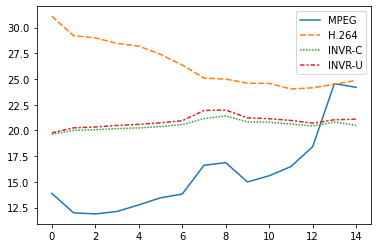

In [ ]:
# Frame-wise PSNR
sns.lineplot(data=psnr_df)

In [ ]:
i = 45

# Image grid
rgb_uncomp = clamp_image(torch.reshape(
    models[int(i/frames_per_chunk)](encoded[(i, height, width)]), [height, width, 3]))
rgb_uncomp = cv2.normalize(src=rgb_uncomp.detach().cpu().numpy(), dst=None, alpha=0, beta=255,
                         norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
rgb_uncomp = np.fliplr(rgb_uncomp.reshape(-1,3)).reshape(rgb_uncomp.shape)

rgb_comp = clamp_image(torch.reshape(
    decoded_models[int(i/frames_per_chunk)](encoded[(i, height, width)]), [height, width, 3]))
rgb_comp = cv2.normalize(src=rgb_comp.detach().cpu().numpy(), dst=None, alpha=0, beta=255,
              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
rgb_comp = np.fliplr(rgb_comp.reshape(-1,3)).reshape(rgb_comp.shape)

rgb_mpeg = get_frame_ext(45, cap_ext=cap_mpeg)
rgb_mpeg = np.fliplr(rgb_mpeg.reshape(-1,3)).reshape(rgb_mpeg.shape)

rgb_h264 = get_frame_ext(45, cap_ext=cap_h264)
rgb_h264 = np.fliplr(rgb_h264.reshape(-1, 3)).reshape(rgb_h264.shape)

rgb_orig = cv2.normalize(src=frames[45].detach().cpu().numpy(), dst=None, alpha=0, beta=255,
              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
rgb_orig = np.fliplr(rgb_orig.reshape(-1,3)).reshape(rgb_orig.shape)

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 3)
f.set_size_inches(18.5, 10.5)
axarr[0, 0].imshow(rgb_orig)
axarr[0, 0].set_title('Original')
axarr[0, 1].imshow(rgb_mpeg)
axarr[0, 1].set_title('MPEG')
axarr[0, 2].imshow(rgb_h264)
axarr[0, 2].set_title('H.264')

axarr[1, 0].imshow(rgb_uncomp)
axarr[1, 0].set_title('INVR-U')
axarr[1, 1].imshow(rgb_comp)
axarr[1, 1].set_title('INVR-C')
axarr[1, 2].imshow(rgb_comp)
axarr[1, 2].set_title('Gaussian')

for axr in axarr:
    for ax in axr:
        ax.set_xticks([])
        ax.set_yticks([])


IndexError: list index out of range

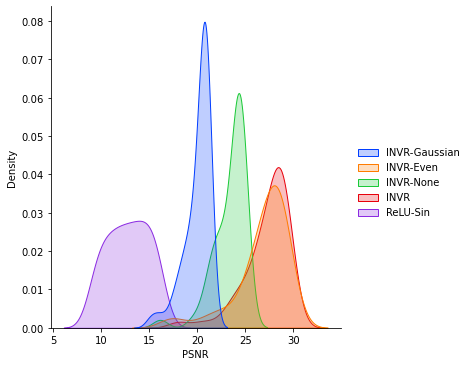

In [ ]:
gauss_bad_psnrs = []
gauss_good_psnrs = []
invr_psnrs = []
invr_52_psnrs = []
invr_none_psnrs = []
relu_psnrs = []

with open("training_psnrs_gauss_bad", "rb") as fp:   # Unpickling
  gauss_bad_psnrs = pickle.load(fp)
with open("training_psnrs_gauss", "rb") as fp:   # Unpickling
  gauss_good_psnrs = pickle.load(fp)
with open("training_psnrs_invr", "rb") as fp:   # Unpickling
  invr_psnrs = pickle.load(fp)
with open("training_psnrs_52", "rb") as fp:   # Unpickling
  invr_52_psnrs = pickle.load(fp)
with open("training_psnrs_no_encoding", "rb") as fp:   # Unpickling
  invr_none_psnrs = pickle.load(fp)
with open("training_psnrs_relu", "rb") as fp:   # Unpickling
  relu_psnrs = pickle.load(fp)

train_psnr_df = pd.DataFrame({
  'Gaussian-SIREN': gauss_good_psnrs,
  'INVR': invr_psnrs,
  'Even-INVR': invr_52_psnrs,
  'None-INVR': invr_none_psnrs,
  'Sin-ReLU': relu_psnrs 
})

train_psnr_df = pd.DataFrame({
  'INVR-Gaussian': gauss_good_psnrs,
  'INVR-Even': invr_52_psnrs,
  'INVR-None': invr_none_psnrs,
  'INVR': invr_psnrs,
  'ReLU-Sin': relu_psnrs 
})

pl = sns.displot(data=train_psnr_df, kind='kde', fill=True, clip=(5, 35),
            palette=sns.color_palette('bright')[:5])
pl.set(xlabel="PSNR")
plt.show()



[Text(0.5, 0, 'Training iterations')]

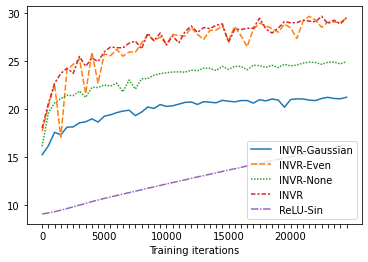

In [ ]:
pl2 = sns.lineplot(data=train_psnr_df)
pl2.set_xticks(range(len(train_psnr_df)), labels=range(0, 25000, 500))
for ind, label in enumerate(pl2.get_xticklabels()):
  if ind % 10 == 0:  # every 10th label is kept
      label.set_visible(True)
  else:
      label.set_visible(False)
      
pl2.set(xlabel="Training iterations")
